In [ ]:
import os
import shutil

base_dir = "/content/tiny-imagenet-200"
val_dir = os.path.join(base_dir, "val")
images_dir = os.path.join(val_dir, "images")
ann_file = os.path.join(val_dir, "val_annotations.txt")

# Read annotations
with open(ann_file) as f:
    annotations = [line.strip().split('\t') for line in f]

# Create class folders and move images
for img, cls, *_ in annotations:
    cls_dir = os.path.join(val_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    shutil.move(
        os.path.join(images_dir, img),
        os.path.join(cls_dir, img)
    )

os.rmdir(images_dir)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfla
import tensorflow.keras.models as tfm
import tensorflow.keras.optimizers as tfo
import tensorflow.keras.losses as tflo
import matplotlib.pyplot as plt

In [ ]:
# load training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/train",
    image_size=(256, 256),
    batch_size=None,
    label_mode="int"
)

# load test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/tiny-imagenet-200/val",
    image_size=(224, 224),
    batch_size=128,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [ ]:
def random_crop(image):
  image = tf.image.random_crop(image, (224, 224, 3))
  image = tf.image.random_flip_left_right(image)
  return image

In [ ]:
train_ds = train_ds.map(lambda x, y: (random_crop(x), y))
train_ds = train_ds.batch(128)

In [ ]:
def normalisation(images):
  mean = tf.constant([0.5, 0.5, 0.5])
  std = tf.constant([0.5, 0.5, 0.5])
  return (images / 255.0 - mean) / std

In [ ]:
train_ds = train_ds.map(lambda x, y: (normalisation(x), y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalisation(x), y))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
for images, _ in train_ds.take(10):
  print(tf.reduce_mean(images))

tf.Tensor(-0.12612447, shape=(), dtype=float32)
tf.Tensor(-0.10457407, shape=(), dtype=float32)
tf.Tensor(-0.13918263, shape=(), dtype=float32)
tf.Tensor(-0.100146785, shape=(), dtype=float32)
tf.Tensor(-0.11728159, shape=(), dtype=float32)
tf.Tensor(-0.15224628, shape=(), dtype=float32)
tf.Tensor(-0.107741244, shape=(), dtype=float32)
tf.Tensor(-0.11011061, shape=(), dtype=float32)
tf.Tensor(-0.09688493, shape=(), dtype=float32)
tf.Tensor(-0.09431439, shape=(), dtype=float32)


In [ ]:
class embeddings(tfla.Layer):
  def __init__(self):
    super().__init__()
    self.cls_token = self.add_weight(
        name="cls_token",
        shape=(1, 1, 768),
        initializer="zeros",
        trainable=True
    )
    self.pos_emb = self.add_weight(
        name="position_embeddings",
        shape=(1, 197, 768),
        initializer="zeros",
        trainable=True
    )
    self.dropout = tfla.Dropout(0.1)

  def call(self, inputs, training=False):
    B = tf.shape(inputs)[0]
    cls_token = tf.tile(self.cls_token, (B, 1, 1))
    x = tf.concat([cls_token, inputs], axis=1)
    x = x + self.pos_emb
    return self.dropout(x, training=training)

In [ ]:
class encoder_block(tfla.Layer):
  def __init__(self):
    super().__init__()
    self.layerNor1 = tfla.LayerNormalization(epsilon=1e-6)
    self.layerNor2 = tfla.LayerNormalization(epsilon=1e-6)

    self.multihead = tfla.MultiHeadAttention(
        num_heads=12,
        key_dim=768 // 12,
        dropout=0.1,
    )

    self.dropout1 = tfla.Dropout(0.1)
    self.dropout2 = tfla.Dropout(0.1)

    self.dense1 = tfla.Dense(768 * 4, activation="gelu")
    self.dense2 = tfla.Dense(768)

  def call(self, inputs, training=False):
    x = self.layerNor1(inputs)
    x = self.multihead(x, x, training=training)
    x = self.dropout1(x, training=training)
    x = inputs + x

    x = self.layerNor2(x)
    y = self.dense1(x)
    y = self.dense2(y)
    x = x + self.dropout2(y, training=training)
    return x

In [ ]:
inputs = tfla.Input(shape=(224, 224, 3))

x = tfla.Conv2D(768, 16, strides=(16, 16), padding="valid", name="patch_embeddings")(inputs)
x = tfla.Reshape((-1, 768))(x)

x = embeddings()(x)
x = tfla.Dropout(0.1)(x)

blocks = [encoder_block() for _ in range(12)]
for block in blocks:
  x = block(x)

x = tfla.LayerNormalization(epsilon=1e-6)(x)
cls_token = x[:, 0, :]

outputs = tfla.Dense(200)(cls_token)

model = tfm.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embeddings (Conv2D)       │ (None, 14, 14, 768)    │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (embeddings)         │ (None, 197, 768)       │       152,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block (encoder_block)   │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_1 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_2 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_3 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_4 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_5 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_6 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_7 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_8 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_9 (encoder_block) │ (None, 197, 768)       │     7,087,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_10                │ (None, 197, 768)       │     7,087,872 │
│ (encoder_block)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_11                │ (None, 197, 768)       │     7,087,872 │
│ (encoder_block)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_24          │ (None, 197, 768)       │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │       153,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,952,456 (327.88 MB)

 Trainable params: 85,952,456 (327.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tfo.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.95,
    epsilon=1e-8,
    )
loss = tflo.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
def lr_schedule(epoch, lr):
  if(epoch < 20):
    return(1e-3)
  else:
    if(epoch < 40):
      return(1e-4)
    else:
      return(1e-5)

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(train_ds, epochs=40, callbacks=[lr_callback])

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - accuracy: 0.0046 - loss: 5.6225 - learning_rate: 0.0010
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1167s 1s/step - accuracy: 0.0047 - loss: 5.3671 - learning_rate: 0.0010
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1167s 1s/step - accuracy: 0.0050 - loss: 5.3207 - learning_rate: 0.0010
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.0051 - loss: 5.3067 - learning_rate: 0.0010
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1166s 1s/step - accuracy: 0.0056 - loss: 5.3017 - learning_rate: 0.0010
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1165s 1s/step - accuracy: 0.0056 - loss: 5.3009 - learning_rate: 0.0010
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1165s 1s/step - accuracy: 0.0055 - loss: 5.2993 - learning_rate: 0.0010
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.0060 - loss: 5.2995 - learning_rate: 0.0010
Epoch 9/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1164s 1s/step - accuracy: 0.0063 - loss: 5.2987 - learning_rate:

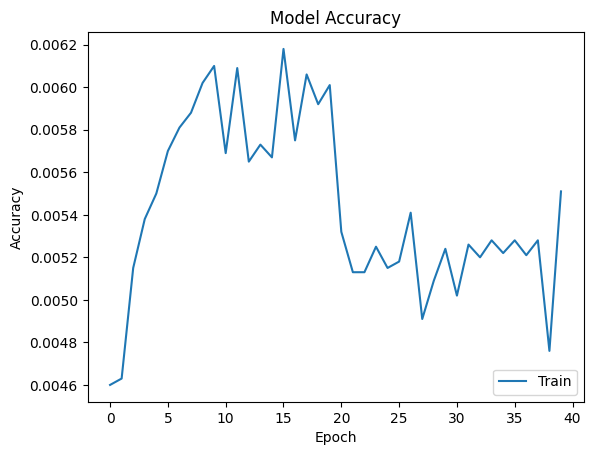

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()